https://www.kaggle.com/brendan45774/chess-piece-dectection

In [1]:
!pip install imageai

     |████████████████████████████████| 160 kB 287 kB/s            
     |████████████████████████████████| 2.9 MB 2.0 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 11.6 MB 53.2 MB/s            
     |████████████████████████████████| 2.1 MB 54.3 MB/s            
     |████████████████████████████████| 14.9 MB 48.3 MB/s            
     |████████████████████████████████| 26.1 MB 835 kB/s             
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=6072e8a5827370df7dbd6464d5f437a27ea02ceeedb80933a087c67fcb253bd3
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Unins

In [2]:
import numpy as np
import os
import shutil
from pathlib import Path

from imageai.Detection import ObjectDetection
from imageai.Detection.Custom import DetectionModelTrainer
from imageai.Detection.Custom import CustomObjectDetection

In [3]:
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("../input/gb-pretrainedyolov3h5/pretrained-yolov3.h5")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image='../input/chess-piece-dectection/images/chess0.png',
                                             output_image_path='./detected.png',
                                             minimum_percentage_probability=30)

for eachObject in detections:
    print(eachObject["name"] , " : ", eachObject["percentage_probability"], " : ", eachObject["box_points"] )
    print("--------------------------------")

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


bottle  :  39.340975880622864  :  [42, 123, 125, 219]
--------------------------------
bottle  :  45.077067613601685  :  [88, 100, 133, 155]
--------------------------------


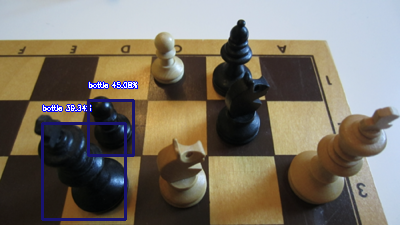

In [4]:
from PIL import Image
Image.open('./detected.png')

In [5]:
root_annots_path = '../input/chess-piece-dectection/annotations/'
root_images_path = '../input/chess-piece-dectection/images/'

annots_path = sorted([i for i in Path(root_annots_path).glob('*.xml')])
images_path = sorted([i for i in Path(root_images_path).glob('*.png')])

n_imgs = len(images_path)

In [6]:
with open(annots_path[6], 'r') as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>chess14.png</filename>
    <size>
        <width>400</width>
        <height>225</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>black-bishop</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>184</xmin>
            <ymin>54</ymin>
            <xmax>238</xmax>
            <ymax>152</ymax>
        </bndbox>
    </object>
</annotation>


In [7]:
set_classes = set()

for annot in annots_path:
    with open(annot, 'r') as f:
        string = f.read()
        name = string[string.find('<name>')+6:string.find('</name>')]
        set_classes.add(name)

classes = np.array(list(set_classes))
print(classes)

['black-king' 'white-queen' 'black-knight' 'white-pawn' 'black-pawn'
 'white-knight' 'white-king' 'white-bishop' 'black-queen' 'black-bishop'
 'white-rook' 'black-rook']


In [8]:
os.makedirs('../imageai/data/train/images', exist_ok=True)
os.makedirs('../imageai/data/train/annotations', exist_ok=True)

os.makedirs('../imageai/data/validation/images', exist_ok=True)
os.makedirs('../imageai/data/validation/annotations', exist_ok=True)

os.makedirs('../imageai/data/test/images', exist_ok=True)
os.makedirs('../imageai/data/test/annotations', exist_ok=True)

In [9]:
n_imgs = 81
n_split = n_imgs // 6


for i, (annot_path, img_path) in enumerate(zip(annots_path, images_path)):    
    if i > n_imgs:
        break
    # train-val-test split
    if i < n_split:
        shutil.copy(img_path, '../imageai/data/test/images/' + img_path.parts[-1])
        shutil.copy(annot_path, '../imageai/data/test/annotations/' + annot_path.parts[-1])
    elif n_split <= i < n_split*2:
        shutil.copy(img_path, '../imageai/data/validation/images/' + img_path.parts[-1])
        shutil.copy(annot_path, '../imageai/data/validation/annotations/' + annot_path.parts[-1])
    else:
        shutil.copy(img_path, '../imageai/data/train/images/' + img_path.parts[-1])
        shutil.copy(annot_path, '../imageai/data/train/annotations/' + annot_path.parts[-1])

In [10]:
print(len(list(Path('../imageai/data/train/annotations/').glob('*.xml'))))
print(len(list(Path('../imageai/data/validation/annotations/').glob('*.xml'))))
print(len(list(Path('../imageai/data/test/annotations/').glob('*.xml'))))

55
13
13


In [11]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="../imageai/data/")
trainer.setTrainConfig(object_names_array=classes,
                       batch_size=8,
                       num_experiments=30,
                       train_from_pretrained_model="../input/gb-pretrainedyolov3h5/pretrained-yolov3.h5")

trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.81
Anchor Boxes generated.
Detection configuration saved in  ../imageai/data/json/detection_config.json
Evaluating over 13 samples taken from ../imageai/data/validation
Training over 55 samples  given at ../imageai/data/train
Training on: 	['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']
Training with Batch Size:  8
Number of Training Samples:  55
Number of Validation Samples:  13
Number of Experiments:  30
Training with transfer learning from pretrained Model


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
56/56 [==============================] - 45s 764ms/step - loss: 150.2941 - yolo_layer_loss: 19.7849 - yolo_layer_1_loss: 41.3497 - yolo_layer_2_loss: 77.5827 - val_loss: 188.1428 - val_yolo_layer_loss: 22.3257 - val_yolo_layer_1_loss: 44.5697 - val_yolo_layer_2_loss: 109.6692
Epoch 2/30
56/56 [==============================] - 40s 691ms/step - loss: 87.0549 - yolo_layer_loss: 14.4691 - yolo_layer_1_loss: 23.6886 - yolo_layer_2_loss: 37.3181 - val_loss: 114.5371 - val_yolo_layer_loss: 16.1079 - val_yolo_layer_1_loss: 24.2809 - val_yolo_layer_2_loss: 62.5692
Epoch 3/30
56/56 [==============================] - 38s 675ms/step - loss: 72.2524 - yolo_layer_loss: 12.0557 - yolo_layer_1_loss: 18.6793 - yolo_layer_2_loss: 29.9403 - val_loss: 94.1990 - val_yolo_layer_loss: 17.9126 - val_yolo_layer_1_loss: 24.8377 - val_yolo_layer_2_loss: 39.8756
Epoch 4/30
56/56 [==============================] - 38s 679ms/step - loss: 59.9174 - yolo_layer_loss: 8.5497 - yolo_layer_1_loss: 13.3591 - y

In [12]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="../imageai/data/")

last_model_name = sorted(os.listdir("../imageai/data/models/"))[-1]
metrics = trainer.evaluateModel(model_path=f"../imageai/data/models/{last_model_name}",
                                json_path="../imageai/data/json/detection_config.json",
                                iou_threshold=0.2,
                                object_threshold=0.3,
                                nms_threshold=0.5)

Starting Model evaluation....
Evaluating over 13 samples taken from ../imageai/data/validation
Training over 55 samples  given at ../imageai/data/train
Model File:  ../imageai/data/models/detection_model-ex-027--loss-0035.635.h5 

Evaluation samples:  13
Using IoU:  0.2
Using Object Threshold:  0.3
Using Non-Maximum Suppression:  0.5
black-bishop: 0.0127
black-king: 0.0000
black-knight: 0.0000
black-pawn: 0.7847
black-queen: 0.0000
black-rook: 0.1250
white-bishop: 0.0000
white-king: 0.0000
white-knight: 0.0476
white-pawn: 0.3413
white-queen: 0.0000
white-rook: 0.0000
mAP: 0.1093


In [13]:
detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(f"../imageai/data/models/{last_model_name}")
detector.setJsonPath("../imageai/data/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=50,
                                             input_image="../imageai/data/validation/images/chess20.png",
                                             output_image_path="../imageai/detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

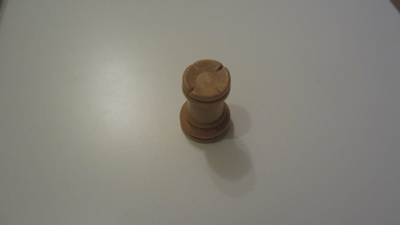

In [14]:
from PIL import Image
Image.open('../imageai/detected.jpg')